## Import

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [4]:
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

## Load model

In [7]:
%run ../models/report_generation/__init__.py
%run ../models/checkpoint/__init__.py

In [8]:
# run_name = '0716_211601_lstm-att_lr0.0001_densenet-121'
# run_name = '0115_175006_h-lstm-att-v2_lr0.001_satt_densenet-121-v2_noes'
run_name = '0115_064249_h-lstm-att-v2_lr0.001_densenet-121-v2_noes_front'
debug = False

In [9]:
compiled_model = load_compiled_model_report_generation(run_name,
                                                       debug=debug,
                                                       device=DEVICE,
                                                      )

_ = compiled_model.model.eval()
compiled_model.metadata['decoder_kwargs']

{'decoder_name': 'h-lstm-att-v2',
 'vocab_size': 1684,
 'embedding_size': 100,
 'hidden_size': 100,
 'features_size': 1024,
 'teacher_forcing': True}

In [10]:
VOCAB = compiled_model.metadata['vocab']
len(VOCAB)

1684

## Load data

In [11]:
%run ../datasets/iu_xray.py
%run ../utils/nlp.py

In [12]:
dataset_kwargs = {
    'max_samples': None,
    'frontal_only': True,
    'image_size': (512, 512),
    'vocab': VOCAB,
}

train_dataset = IUXRayDataset(dataset_type='train', **dataset_kwargs)
val_dataset = IUXRayDataset(dataset_type='val', **dataset_kwargs)
test_dataset = IUXRayDataset(dataset_type='test', **dataset_kwargs)
len(train_dataset), len(val_dataset), len(test_dataset)

(3031, 385, 384)

## Eval

In [13]:
from captum.attr import visualization
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize

In [14]:
%run ../training/report_generation/hierarchical.py
%run ../utils/common.py
%run ../utils/nlp.py

In [15]:
report_reader = ReportReader(compiled_model.metadata['vocab'])

In [21]:
def eval_sample(compiled_model, image, report,
                show=True, device=DEVICE, free=False, **kwargs):
    is_hierarchical = compiled_model.metadata['decoder_kwargs']['decoder_name'].startswith('h-')
    
    # Prepare inputs
    images = image.unsqueeze(0).to(device)
    if is_hierarchical:
        reports = split_sentences_and_pad(report)
    else:
        reports = torch.tensor(report)

    reports = reports.unsqueeze(0).to(device)
    
    # Pass thru model
    if not is_hierarchical:
        del kwargs['max_sentences']
    tup = compiled_model.model(images, reports, free=free, **kwargs)
    
    # Parse outputs
    if is_hierarchical:
        generated = _flatten_gen_reports(tup[0], tup[1])
    else:
        generated = tup[0]
        _, generated = generated.max(dim=-1)

    generated = generated.squeeze(0).cpu()
    
    # Print result
    original_report = report_reader.idx_to_text(report)
    generated_report = report_reader.idx_to_text(generated)
    if show:
        print('GROUND TRUTH:\n', original_report)
        print('-'*20)
        print('GENERATED:\n', generated_report)
        
    return original_report, generated_report, tup

In [22]:
idx = 20

item = train_dataset[idx]
image = item.image
report = item.report

gt, gen, other = eval_sample(compiled_model, image, report,
                             free=True, max_sentences=100, max_words=40)

GROUND TRUTH:
 heart size normal . lungs are clear .
--------------------
GENERATED:
 the heart is normal in size . the lungs are clear . there is no pleural effusion or pneumothorax . there is no pneumothorax or pleural effusion . there is no pneumothorax or pleural effusion . there is no pneumothorax or pleural effusion . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PA

In [60]:
stops = other[1].detach().cpu()
# stops = stops[0]
print(stops.size())
stops

torch.Size([1, 9])


tensor([[0.0008, 0.0248, 0.0444, 0.0469, 0.0508, 0.0755, 0.2298, 0.4964, 0.6902]])

In [61]:
out_words = other[0].detach().squeeze(0)
out_words = out_words.argmax(dim=-1)
out_words.size()

torch.Size([9, 100])

In [62]:
scores = other[2].detach().squeeze(0).cpu()
scores.size()

torch.Size([9, 16, 16])

In [63]:
image_color = image.detach().permute(1, 2, 0).cpu().numpy()
image_color = arr_to_range(image_color)

image_color.shape

(512, 512, 3)

In [67]:
sentence_idx = 1
heatmap = scores[sentence_idx].numpy()
heatmap = gray2rgb(heatmap)
heatmap = resize(heatmap, image_color.shape)
heatmap.shape

(512, 512, 3)

In [68]:
report_reader.idx_to_text(out_words[sentence_idx])

'the lungs are clear . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

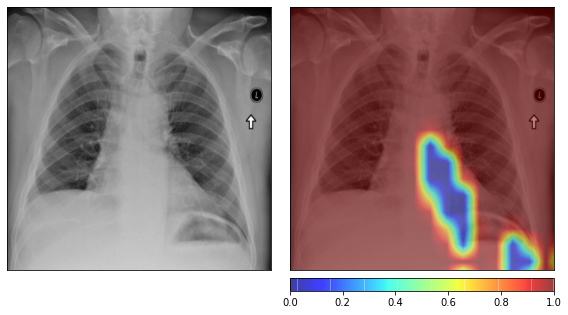

(<Figure size 576x432 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d172ee470>,
       dtype=object))

In [69]:
visualization.visualize_image_attr_multiple(heatmap,
                                            image_color,
                                            methods=['original_image',
                                                     'blended_heat_map'],
                                            signs=['all', 'positive'],
                                            cmap='jet',
                                            show_colorbar=True,
                                           )

## Debug report-reader

In [45]:
%run ../utils/nlp.py

In [46]:
report_reader = ReportReader(compiled_model.metadata['vocab'], ignore_pad=True)

In [48]:
idx = 20

item = train_dataset[idx]
images = item.image
images = item.image.unsqueeze(0).to(DEVICE)
reports = split_sentences_and_pad(item.report)

out = compiled_model.model(images, reports, free=False)
out = out[0].argmax(dim=-1).squeeze(0).detach().cpu()
out.size()

torch.Size([4, 4])

In [49]:
out

tensor([[ 5, 52, 16, 13],
        [ 5, 32, 11, 50],
        [15, 16, 17, 25],
        [15, 16, 17, 28]])

In [50]:
report_reader.idx_to_text(out)

'the heart is normal ADOT the lungs are clear ADOT there is no pleural ADOT there is no pneumothorax ADOT'

In [31]:
out.tolist()

[[5, 52, 16, 13], [5, 32, 11, 50], [15, 16, 17, 25], [15, 16, 17, 28]]